# Event Detection Demystified

This notebook derives a basic event detection technique and shows an application on real streamflow data.

## Requirements

The following examples require python 3.8+, pandas, numpy, matplotlib, seaborn, and [evaluation_tools](https://github.com/NOAA-OWP/evaluation_tools). The Makefile in this repository will automatically generate a compatible Python virtual environment. Running `make events` will create the required environment and launch this notebook in your browser.

## Background and Motivation

Event-based analysis is commonly conducted using [baseflow separation](https://doi.org/10.1002/hyp.5675) techniques. Baseflow separation is the process of modeling the underlying low frequency components in a streamflow hydrograph to identify periods of event flow. Quite often "event" refers to a rainfall-driven direct runoff storm-event. Generally speaking, most of the interesting hydrology happens during these events. Hydrologists are interested in analyzing these events to uncover the dynamic processes that govern a catchment's streamflow response to precipitation.

The figure below shows an example of using baseflow separation to divide a streamflow hydrograph into baseflow and direct runoff components. Contiguous periods of direct runoff are "events". The figure below shows three such events. This figure was generated assuming baseflow linearly increased during storm events by 0.04 cubic feet per second. This example does not include any event filtering to eliminate small fluctuations or "noisy" events.

![](images/baseflow.png)

It may be easy to identify and analyze a single event. However, manually extracting events becomes tedious as the amount of data and the number of events increases. It's also difficult to manually extract events in an objective and standardized way. We can use a variety of signal processing techniques to automatically identify and analyze hydrological events in long streamflow records. The process of automatically identifying interesting hydrological events in streamflow time series is called *Event Detection*.

## Overview

This example consists of 7 high-level steps from data retrieval and preprocessing through a concise description of the methods employed to find and isolate hydrological events and concludes with a simple event-based analysis. 

1. Retrieve and prepare data
2. Filter noise and model trend
3. Detrend data
4. Apply in-event criteria
5. Discretize events
6. Tweak event start and end times
7. Filter events

## 1. Retrieve and Prepare Data

Here we use the Evaluation Tools [NWIS Client](https://noaa-owp.github.io/evaluation_tools/evaluation_tools.nwis_client.html) subpackage to retrieve streamflow measurements from the [USGS Instantaneous Values Web Service](https://waterservices.usgs.gov/rest/IV-Service.html) for [Little Hope Creek](https://waterdata.usgs.gov/nc/nwis/uv?site_no=02146470) in North Carolina. We also clean and resample the data to prepare them for event detection.

The Event Detection subpackage in Evaluation Tools operates on time series data. In general terms a time series is a time-stamped series of regularly sampled values. These values can be streamflow measurements or modeled values. In the context of Evaluation Tools, these time series are normally stored as `pandas.Series` with a monotonically increasing `pandas.DatetimeIndex`. For more information on using `pandas` see the [Pandas API Reference](https://pandas.pydata.org/pandas-docs/stable/reference/index.html).

In [1]:
# Import modules
from evaluation_tools.nwis_client.iv import IVDataService
from evaluation_tools.events.event_detection import decomposition as ev
import numpy as np
import pandas as pd
import pubtools.plot as plt
%matplotlib inline

# Retrieve streamflow data
observations = IVDataService.get(
    sites='02146470',
    startDT='2019-10-01',
    endDT='2020-09-30'
    )

# Isolate time series of streamflow measurements
observations = observations[['value_date', 'value']]
observations = observations.drop_duplicates(subset=['value_date'])
observations = observations.set_index('value_date')
observations = observations.resample('H').first().ffill()

# Look at data
observations.head()

,value
value_date,
2019-09-30 23:00:00,0.72
2019-10-01 00:00:00,0.72
2019-10-01 01:00:00,0.72
2019-10-01 02:00:00,0.72
2019-10-01 03:00:00,0.79


## 2. Filter Noise and Model Trend

The first issue to address with real data is noise. Small high-frequency fluctations in real data may be erroneously identified as "events" by any event detection algorithm. To reduce the number of false positive events it's important to filter the data before applying event detection. Here we applied an [exponentially weight moving average](https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average) to the data to smooth out these noisy fluctuations.

Next we can employ a variety of filters to model the low-frequency trend component of a streamflow time series. Here we use a rolling minimum filter to model the trend.

In [2]:
# Smooth noisy data
observations['smooth'] = observations['value'].ewm(halflife='6H', times=observations.index).mean()

# Model the trend using a 7-day rolling minimum
observations['trend'] = ev.rolling_minimum(observations['smooth'], '7D')

# Look at data
observations.head()

,value,smooth,trend
value_date,,,
2019-09-30 23:00:00,0.72,0.720000,0.72
2019-10-01 00:00:00,0.72,0.720000,0.72
2019-10-01 01:00:00,0.72,0.720000,0.72
2019-10-01 02:00:00,0.72,0.720000,0.72
2019-10-01 03:00:00,0.79,0.737406,0.72


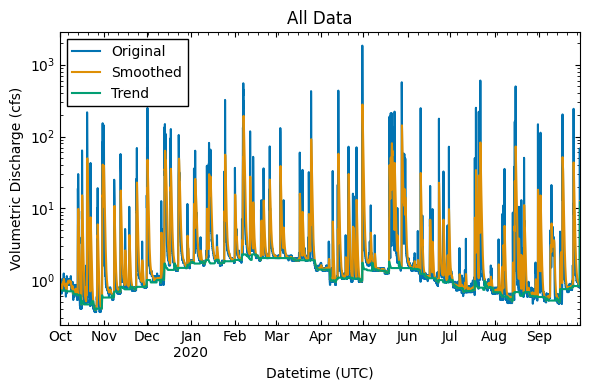

In [3]:
# Plot all data
plt.plot_dataframe(
    observations,
    logy=True,
    legend=['Original', 'Smoothed', 'Trend'], 
    xlabel="Datetime (UTC)",
    ylabel="Volumetric Discharge (cfs)",
    title="All Data"
    )

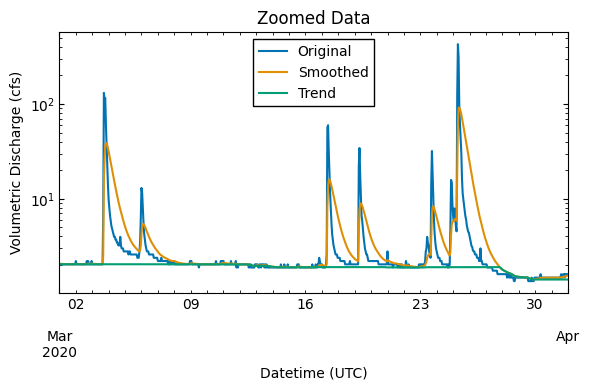

In [4]:
# Detailed plot
begin = pd.Timestamp("2020-03-01")
end = pd.Timestamp("2020-04-01")
plt.plot_dataframe(
    observations.loc[begin:end, :],
    logy=True,
    legend=['Original', 'Smoothed', 'Trend'], 
    xlabel="Datetime (UTC)",
    ylabel="Volumetric Discharge (cfs)",
    title="Zoomed Data"
    )

## 3. Detrend Data

In [ ]:
# Detrend the data
observations['detrended'] = observations['smooth'].sub(observations['trend'])

# Ignore detrended values below measurement precision
observations.loc[(observations['detrended'] < 0.01), 'detrended'] = 0.0

# Detrended signal should have a zero median
residual = observations['detrended'].median() * 2.0
observations.loc[(observations['detrended'] < residual), 'detrended'] = 0.0

## 4. Apply In-event Criteria

In [5]:
# Mask in-event measurements
observations['in_event'] = (observations['detrended'] > 0.0)

# Look at data
observations.head()

,value,smooth,trend,detrended,in_event
value_date,,,,,
2019-09-30 23:00:00,0.72,0.720000,0.72,0.0,False
2019-10-01 00:00:00,0.72,0.720000,0.72,0.0,False
2019-10-01 01:00:00,0.72,0.720000,0.72,0.0,False
2019-10-01 02:00:00,0.72,0.720000,0.72,0.0,False
2019-10-01 03:00:00,0.79,0.737406,0.72,0.0,False


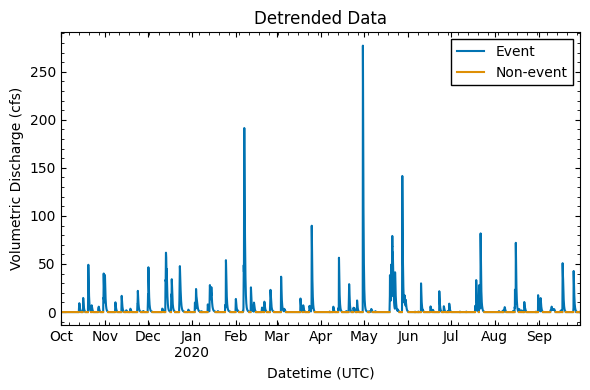

In [6]:
# Plot all detrended data
observations['zeros'] = observations.loc[observations['detrended'] == 0.0, 'detrended']
plt.plot_dataframe(
    observations[['detrended', 'zeros']],
    logy=False,
    legend=['Event', 'Non-event'], 
    xlabel="Datetime (UTC)",
    ylabel="Volumetric Discharge (cfs)",
    title="Detrended Data"
    )

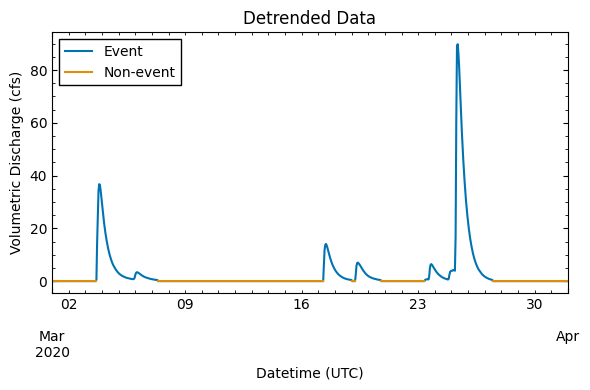

In [7]:
# Detailed plot of detrended data
plt.plot_dataframe(
    observations.loc[begin:end, ['detrended', 'zeros']],
    logy=False,
    legend=['Event', 'Non-event'], 
    xlabel="Datetime (UTC)",
    ylabel="Volumetric Discharge (cfs)",
    title="Zoomed Detrended Data"
    )

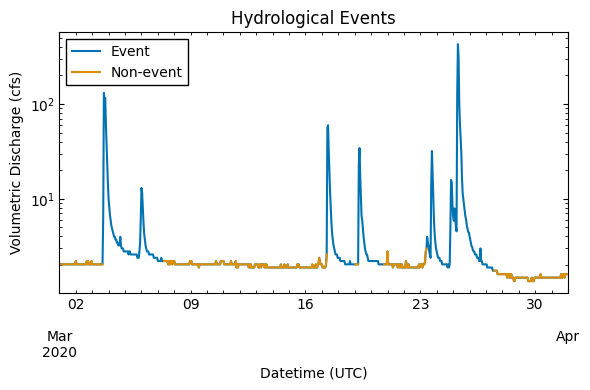

In [8]:
# Detailed plot of detrended real data
subset = observations.loc[begin:end, :].copy(deep=True)
subset.loc[~subset['in_event'], 'zeros'] = subset.loc[~subset['in_event'], 'value']
plt.plot_dataframe(
    subset[['value', 'zeros']],
    logy=True,
    legend=['Event', 'Non-event'], 
    xlabel="Datetime (UTC)",
    ylabel="Volumetric Discharge (cfs)",
    title="Hydrological Events"
    )

## 5. Discretize Events

In [ ]:
# Aggregate continguous event measurements into discrete events
events = ev.event_boundaries(observations['in_event'])

## 6. Tweak Event Start and End Times

In [9]:
# Tweak events
events['start'] = events['start'].apply(ev.find_local_minimum, radius='7H', timeseries=observations['value'])

# Adjust event points and inspect
subset['zeros'] = subset['value']
for e in events.itertuples():
    subset.loc[e.start:e.end, 'zeros'] = np.nan

# Look at events
events.head()

,start,end
0,2019-10-13 10:00:00,2019-10-15 05:00:00
1,2019-10-16 02:00:00,2019-10-18 05:00:00
2,2019-10-19 19:00:00,2019-10-22 05:00:00
3,2019-10-22 07:00:00,2019-10-23 20:00:00
4,2019-10-27 01:00:00,2019-10-28 19:00:00


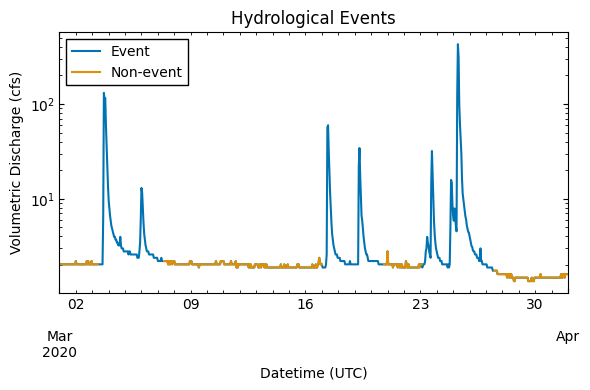

In [10]:
# Plot new events
plt.plot_dataframe(
    subset[['value', 'zeros']],
    logy=True,
    legend=['Event', 'Non-event'], 
    xlabel="Datetime (UTC)",
    ylabel="Volumetric Discharge (cfs)",
    title="Hydrological Events"
    )

## 7. Filter Events

In [11]:
# Compute event durations in hours
events['duration'] = (events['end'].sub(events['start'])).div(pd.Timedelta('1H'))

# Compute peak flows in cfs
events['peak'] = events.apply(
    lambda e: observations['value'].loc[e.start:e.end].max(),
    axis=1
    )

# Filter out small events less than 6 hours or with peaks less than 10 CFS
events = events[events['duration'] >= 6.0]
events = events[events['peak'] >= 10.0]

# Look at events
events.head()

,start,end,duration,peak
0,2019-10-13 10:00:00,2019-10-15 05:00:00,43.0,30.000000
1,2019-10-16 02:00:00,2019-10-18 05:00:00,51.0,63.900002
2,2019-10-19 19:00:00,2019-10-22 05:00:00,58.0,217.000000
3,2019-10-22 07:00:00,2019-10-23 20:00:00,37.0,42.799999
4,2019-10-27 01:00:00,2019-10-28 19:00:00,42.0,19.100000


## Example Event-Based Analyses

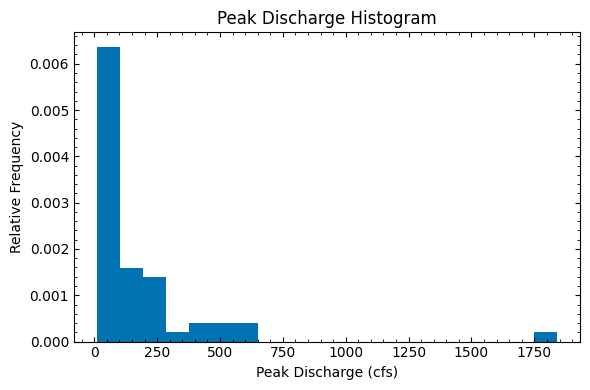

In [12]:
# Plot histogram of peaks and durations
plt.hist(
    events['peak'],
    xlabel="Peak Discharge (cfs)",
    ylabel="Relative Frequency",
    title="Peak Discharge Histogram"
    )

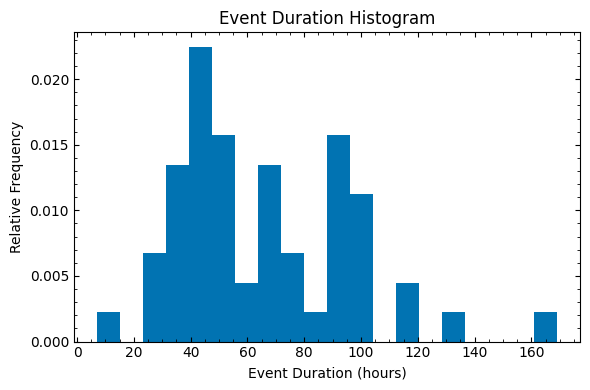

In [13]:
# Plot histogram of durations
plt.hist(
    events['duration'],
    xlabel="Event Duration (hours)",
    ylabel="Relative Frequency",
    title="Event Duration Histogram"
    )